In [1]:
# Урок отсюда
# https://habrahabr.ru/company/ods/blog/325654/

# Сам алгоритм DBSCAN переложенный на python
# https://algorithmicthoughts.wordpress.com/2013/05/29/machine-learning-dbscan/

# PCA и KMEANS
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

# k-means в действии
# http://blog.esemi.ru/2012/08/k-means-python.html

### SVD (сингулярное разложение матриц) и KMEANS в файле 'lesson1'

import numpy as np
#Аггломеративная кластеризация (neighbour joining)
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD # для SVD + KMeans

from sklearn.decomposition import PCA # метод главных компонент для снижения размерности
from sklearn.manifold import TSNE

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn import datasets # Ирисы Фишера

# функция, которая считает расстояния между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

In [106]:
# Загрузим датасет
iris = datasets.load_iris()
X = iris.data
y = iris.target
print('X', X.shape,':\n', X[:3])
print('y', y.shape,':\n', y[:5])

X (150, 4) :
 [[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]]
y (150,) :
 [0 0 0 0 0]


[]

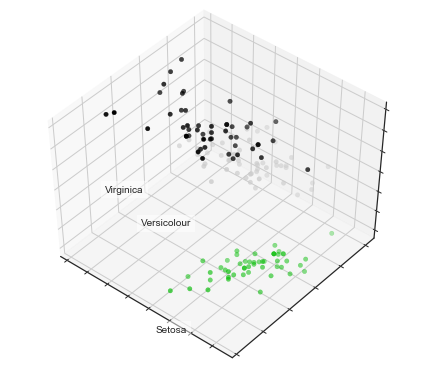

In [44]:
# Заведём красивую трёхмерную картинку с раскраской по меткам, используя 3 координаты из 4
fig = plt.figure(1, figsize=(6, 5))
plt.clf() # очистить активное окно
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev = 48, azim = 130) # elev и azim угловая высота и азимут точки наблюдения
plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(), # координаты, положение всех подписей одновременно
              X[y == label, 1].mean() + 1.5, # если убрать + 1.5, то подписи будут в центре
              X[y == label, 2].mean(), name,
              # horizontalalignment и verticalalignment определяют положение текста относительно точки привязки
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Поменяем порядок цветов меток, чтобы они соответствовали правильному
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = y_clr, cmap = plt.cm.spectral) # вместо spectral можно написать др раскраску

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

### PCA

In [49]:
# Используем PCA для этой модели

# Сначала обучим модель
# Выделим из наших данных валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth = 2, random_state = 42) # Можно поиграть с глубиной
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test) # вероятности отнесения к каждому классу
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, preds.argmax(axis=1))))


Accuracy: 0.88889


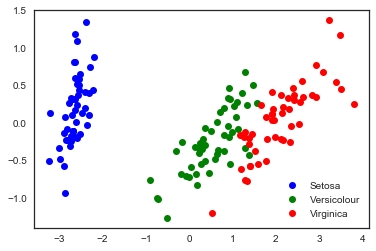

In [111]:
# Сначала отрисуем не прогнозы, а исходный датасет
# Прогоним встроенный в sklearn PCA
pca = PCA(n_components = 2)
X_centered = X - X.mean(axis = 0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

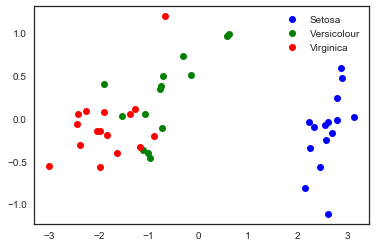

In [78]:
# отрисуем тестовую выборку. сначала преобразуем вероятности к вектору ответов
v = np.zeros(len(preds))
for i in range(len(preds)):
    pos = 0
    max = 0
    for j in range(len(preds[0])):
        if preds[i][j] > max:
            max = preds[i][j]
            pos = j
    v[i] = pos
print(v)
print(preds)

# Обучим PCA
pca = PCA(n_components = 2)
X_centered = X_test - X_test.mean(axis = 0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[v == 0, 0], X_pca[v == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[v == 1, 0], X_pca[v == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[v == 2, 0], X_pca[v == 2, 1], 'ro', label='Virginica')
plt.legend(loc = 0);

In [84]:
# хорошо применять PCA непосредственно перед обучением модели
# Повторим то же самое разбиение на валидацию и тренировочную выборку.
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, stratify = y, random_state = 42)

clf = DecisionTreeClassifier(max_depth = 2, random_state = 42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, preds.argmax(axis=1))))

# Поразительно. точность возрасла

Accuracy: 0.91111


In [86]:
# Посмотрим на 2 главные компоненты в последнем PCA-представлении данных и на тот процент
# исходной дисперсии в даных, который они "объясняют".

for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
      for value, name in zip(component, iris.feature_names)))

1 component: 92.46% of initial variance
0.362 x sepal length (cm) + -0.082 x sepal width (cm) + 0.857 x petal length (cm) + 0.359 x petal width (cm)
2 component: 5.3% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.176 x petal length (cm) + -0.075 x petal width (cm)


### t-SNE

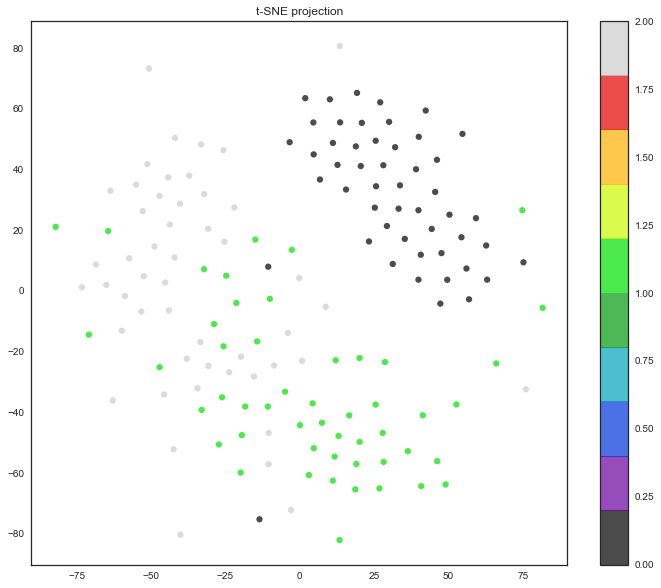

In [89]:
tsne = TSNE(random_state = 17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y, edgecolor = 'none', alpha = 0.7, s = 40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('t-SNE projection')
# На некоторых наборах работает лучше. Надо смотреть
# На практике, как правило, выбирают столько главных компонент, чтобы оставить 90% дисперсии исходных данных

Чтобы сохранить 95% дисперсии, нужна размерность:  2


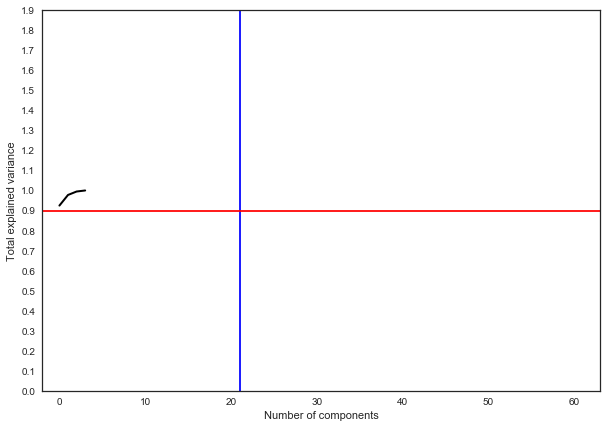

In [103]:
# Можно посмотреть наглядно, сколько компонент можно убрать, чтобы сохранить 90% разброса
# чёрная кривая выражает эту зависимость. пока просто простой случай
pca = PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'k', lw = 2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(-2, 63)
plt.yticks(np.arange(0, 2, 0.1))
plt.axvline(21, c = 'b') # можно двигать линии
plt.axhline(0.9, c = 'r')

# Формально можно посчитать так:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('Чтобы сохранить 95% дисперсии, нужна размерность: ', d)

# K-means - РАЗОБАТЬ БЛОК НИЖЕ

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


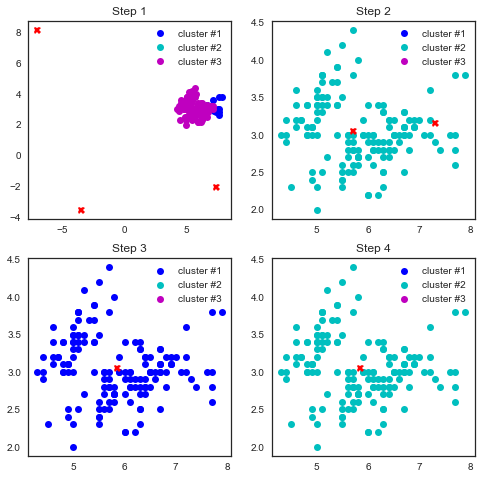

In [120]:
# Чистый алгоритм, без использования библиотечной функции

# Прибьём рандомность и насыпем три случайные центроиды для начала
np.random.seed(seed=42)
centroids = np.random.normal(loc = 0.0, scale = 10, size = 12)
centroids = centroids.reshape((3, 4)) # или 3 и 2, когда точки размерности 2 и надо 3 центра

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиды каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

# А теперь нарисуем всю эту красоту
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc = 0)
    plt.title('Step {:}'.format(i + 1));

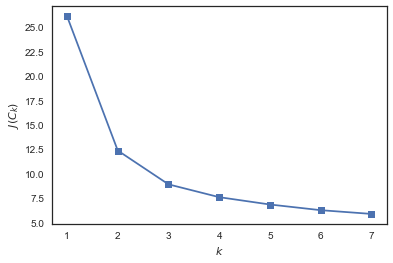

In [123]:
# Предположить, сколько нужно кластеров можно по графику
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker = 's');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

### Библиотечные функции K-means и MiniBatch K-means

## Посмотреть критерий остановки по умолчанию

In [133]:
# вместо MiniBatchKMeans можно использовать просто KMeans
kmeans = MiniBatchKMeans(init='k-means++', n_clusters = 3, random_state = 42).fit(X)
preds = kmeans.labels_
print('kmeans.labels_:\n', preds)
print('y', y)

kmeans.labels_:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
y [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [134]:
# похожи. переименуем кластеры в ответе классификатора
mapping = {0 : 1, 1 : 0, 2 : 2}
mapped_preds = [mapping[pred] for pred in preds]
print('Accuracy: {:.5f}'.format(accuracy_score(y, mapped_preds)))

Accuracy: 0.88667


C:\Users\Дом
